In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import pickle

from sklearn import preprocessing
from sklearn.decomposition import PCA
import scipy.io as sp_io
from scipy.stats import kstest as sp_kstest
from scipy.stats import ttest_ind as sp_ttest

In [2]:
# load gradient
structral_gradient = pd.read_csv("./dat/insula_gredient.tsv", sep="\t", index_col=0, header=None).values[:15].flatten()[4:]
thickness_gradient = np.delete(sp_io.loadmat("./dat/INS_thickness_myelin.mat")['INSthickness'].flatten(), 1)[3:]
myelin_gradient = pd.read_excel("./dat/INSsam_myelin.xlsx", header=None).values.flatten()[4:]

# L2 normalization
all_gradients_scale = [ preprocessing.normalize(gred.reshape(-1, 1), norm="l2", axis=0)  for gred in [structral_gradient,  myelin_gradient, thickness_gradient] ]
structral_gradient.shape, thickness_gradient.shape, myelin_gradient.shape

((11,), (11,), (11,))

In [3]:
# load protein expr of different gene set
## 1. total expr
expr = pd.read_csv("./dat/protomics_expr_processed.tsv", sep="\t", index_col=0)
expr_scale = pd.DataFrame(preprocessing.scale(expr, axis=1), index=expr.index, columns=expr.columns)

select_idx = list(range(4, 15))

## 3. layer marker
layer_marker = pd.read_csv("./dat/layer_marker.genelist", header=None).values.flatten()
idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(layer_marker)
layer_expr = expr_scale.values[idx, :][:, select_idx]

## 4. synaptome
synaptome_genelist = pd.read_csv("./dat/synaptome.genelist", header=None).values.flatten()
synaptome_idx = pd.Series(expr_scale.index).str.split('|', expand=True)[1].isin(synaptome_genelist)
synaptome_expr = expr_scale.values[synaptome_idx, :][:, select_idx]

expr_scale = expr_scale.values[:, select_idx]
expr_scale.shape, layer_expr.shape, synaptome_expr.shape

((6090, 11), (361, 11), (1669, 11))

In [4]:
def calc_explained_variance(gred_norm, cov):
    return np.dot(gred_norm.T, cov).dot(gred_norm)

In [5]:
def calc_explained_variance(gred_norm, cov):
    return np.dot(gred_norm.T, cov).dot(gred_norm)

gene_set_label = ["All", "Layer marker", "Synaptome"]
compare_res_var = []
for i, gene_set_expr in enumerate([expr_scale, layer_expr, synaptome_expr]):
    gene_set_expr= np.array(gene_set_expr)
    pca_obj_15sample = PCA(n_components=1).fit(gene_set_expr.T)
    #pca_obj_14sample = PCA(n_components=1).fit(np.delete(gene_set_expr, 1, axis=1).T)

    comp1_15sample = pca_obj_15sample.fit_transform(gene_set_expr.T)
    #comp1_14sample = pca_obj_14sample.fit_transform(np.delete(gene_set_expr, 1, axis=1).T)

    comp1_15sample_norm = preprocessing.normalize(comp1_15sample, norm="l2", axis=0)
    #comp1_14sample_norm = preprocessing.normalize(comp1_14sample, norm="l2", axis=0)

    cov_15sample = np.cov(gene_set_expr.T)
    #cov_14sample= np.cov(np.delete(gene_set_expr, 1, axis=1).T)

    compare_res_var.append([ calc_explained_variance(all_gradients_scale[0], cov_15sample)[0, 0], 
                             calc_explained_variance(all_gradients_scale[1], cov_15sample)[0, 0],
                             calc_explained_variance(all_gradients_scale[2], cov_15sample)[0, 0], gene_set_label[i] ])

pd.DataFrame(compare_res_var, columns=["Connectivity", "Myelin", "Thickness", "Gene set"])

,Connectivity,Myelin,Thickness,Gene set
0,0.459814,0.428674,0.299235,All
1,0.393904,0.355624,0.272049,Layer marker
2,0.476390,0.439152,0.272342,Synaptome


In [6]:
# bootstrap sampling: estimate the std and distribution of the statistic (captured variance)
boot_vars = []
n_boot = 1000
for i, gene_set_expr in enumerate([expr_scale, layer_expr, synaptome_expr]):
    tmp = np.empty(shape=(n_boot, 3))
    
    # for each gene set, resample the gene with replace and re-calculate the statistic (captured variance) to construct the potential distribution and estimate the std
    n_genes = gene_set_expr.shape[0]
    for k in range(n_boot):
        resampled_idx = np.random.choice(range(n_genes), size=n_genes, replace=True)
        resampled_expr = np.array(gene_set_expr)[resampled_idx, :]

        resampled_cov_15sample = np.cov(resampled_expr.T)
        #resampled_cov_14sample = np.cov(np.delete(resampled_expr, 1, axis=1).T)

        resampled_pc1_15sample = preprocessing.normalize( PCA(n_components=1).fit_transform(resampled_expr.T), norm="l2", axis=0)
        #resampled_pc1_14sample = preprocessing.normalize( PCA(n_components=1).fit_transform(np.delete(resampled_expr, 1, axis=1).T), norm="l2", axis=0)

        tmp[k, :] = [ calc_explained_variance(all_gradients_scale[0], resampled_cov_15sample)[0, 0],
                      calc_explained_variance(all_gradients_scale[1], resampled_cov_15sample)[0, 0],
                      calc_explained_variance(all_gradients_scale[2], resampled_cov_15sample)[0, 0], ]
    boot_vars.append(tmp)

In [7]:
pickle.dump(boot_vars, open("./dat/bootstrap_variance_INS2-4.pkl", "wb"))
boot_vars = pickle.load(open("./dat/bootstrap_variance_INS2-4.pkl","rb"))

In [12]:
# prepare the dat for plot

## dat for bar plot
compare_dat = pd.DataFrame(compare_res_var, columns=["Connectivity", "Myelin", "Thickness", "Gene_sets"])

## calc error bar
compare_std = np.array(boot_vars).std(axis=1)[:, 2:]
upper_line = compare_dat.iloc[:, :3] + compare_std
upper_line["Gene_sets"] = compare_dat["Gene_sets"]
lower_line = compare_dat.iloc[:, :3] - compare_std
lower_line["Gene_sets"] = compare_dat["Gene_sets"]

## chanage data format to match plotnine
compare_dat = compare_dat.melt(id_vars=["Gene_sets"], var_name="Gradient", value_name="Value")
compare_dat["Gradient"] = pd.Categorical(compare_dat["Gradient"], categories=["Connectivity", "Myelin", "Thickness"])
upper_line = upper_line.melt(id_vars=["Gene_sets"], var_name="Gradient", value_name="Upper")
lower_line = lower_line.melt(id_vars=["Gene_sets"], var_name="Gradient", value_name="Lower")
compare_errbar = pd.merge(upper_line, lower_line, how="left")
compare_errbar["Gradient"] = pd.Categorical(compare_errbar["Gradient"], categories=["Connectivity", "Myelin", "Thickness"])
compare_errbar["Value"] = compare_dat['Value']

## dat for plot line segment: 
step = 0.1
seg_line = pd.DataFrame()
seg_line["Gene_sets"] = ["All", "Layer marker", "Synaptome"]
seg_line["y1"] = compare_errbar["Upper"].groupby(compare_errbar["Gene_sets"]).max().values * 1.05
seg_line["y2"] = seg_line["y1"] + step
seg_line["y3"] = seg_line["y2"] + step
seg_line["Gradient"] = "Connectivity"
seg_line2 = seg_line.copy()
seg_line2["Gradient"] = "Myelin"

## dat for annotate the P-val
txt_dat = pd.DataFrame()
txt_dat["Gene_sets"] = ["All", "Layer marker", "Synaptome"]
txt_dat["Gradient"] = "Connectivity"
txt_dat["Label1"] = ""
txt_dat["Label2"] = ""
txt_dat["y1"] = seg_line["y1"] + step/2
txt_dat["y2"] = seg_line["y2"] + step/2

for i, dat in enumerate(boot_vars):
    pval1 = f"P = {sp_kstest(dat[:, 0], dat[:, 1])[-1]:.3e}"
    pval2 = f"P = {sp_kstest(dat[:, 0], dat[:, 2])[-1]:.3e}"

    #pval1 = f"P = {sp_ttest(dat[:, 0], dat[:, 1], equal_var=False)[-1]:.3e}"
    #pval2 = f"P = {sp_ttest(dat[:, 0], dat[:, 2], equal_var=False)[-1]:.3e}"
    txt_dat.loc[i, "Label1"] = pval1
    txt_dat.loc[i, "Label2"] = pval2

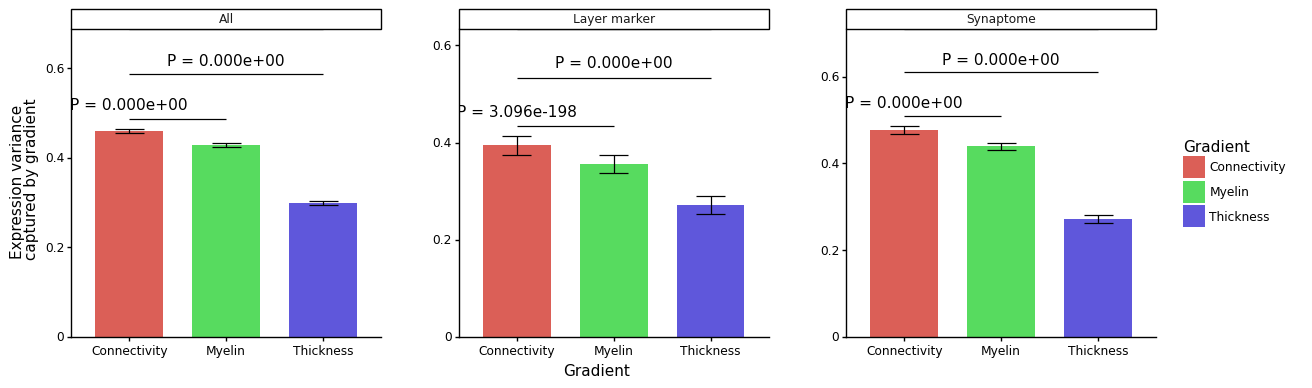

<ggplot: (8739566538870)>

In [14]:
compare_plot = (
    p9.ggplot(p9.aes(x="Gradient", y="Value", fill="Gradient"), compare_dat)
    + p9.geom_bar(stat="identity", width=0.7)
    + p9.geom_errorbar(p9.aes(ymin="Lower", ymax="Upper"), compare_errbar, width=0.3)
    #+ p9.geom_segment(p9.aes(x=0, y="Upper+0.2", xend=1, yend="Upper+0.2"), seg_line)
    + p9.geom_segment(p9.aes(x="Gradient", xend=2, y="y1", yend="y1"), seg_line)
    + p9.geom_segment(p9.aes(x="Gradient", xend=3, y="y2", yend="y2"), seg_line)
    + p9.geom_segment(p9.aes(x="Gradient", xend=3, y="y3", yend="y3"), seg_line)
    + p9.geom_text(p9.aes(x="Gradient", y="y1+0.03", label=txt_dat["Label1"]), seg_line)
    + p9.geom_text(p9.aes(x="Gradient", y="y2+0.03", label=txt_dat["Label2"]), seg_line2)
    + p9.theme_classic()
    + p9.ylab("Expression variance\n captured by gradient")
    + p9.scale_y_continuous(expand = (0, 0))
    + p9.theme(figure_size=(14, 4),
               axis_text=p9.element_text(color="black"),
               subplots_adjust={'wspace': 0.25}
               )
    + p9.guides(fill=p9.guide_legend(order=0))
    + p9.facet_wrap("~Gene_sets", nrow=1, ncol=4, scales="free_y")
)
p9.ggsave(compare_plot, "./compare_gradient_INS2-4.pdf", verbose=False)
compare_plot